In [33]:
import gzip
import lzma
import brotli
import bz2
from datasets import load_dataset

import numpy as np
from tqdm import tqdm
import pandas as pd
import concurrent.futures
from sklearn.model_selection import train_test_split

In [34]:
def get_balanced_dataset(dataset, percentage):
    import warnings
    warnings.filterwarnings("ignore", category=DeprecationWarning) 
    dataset = pd.DataFrame(dataset)
    dataset = dataset[['text', 'label']]
    dataset = dataset.groupby("label").apply(lambda x: x.sample(frac=percentage)).reset_index(drop=True)
    return dataset

In [3]:
dataset = load_dataset("told-br")

/home/yvson/Documents/Faculdade/NLP/NLP-final-project/venv/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for told-br contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/told-br
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [35]:
Categories = ['Non-toxic', 'Toxic']

In [36]:
train , validation = train_test_split(dataset['train'].to_pandas(), test_size=0.13, random_state=42) # esse dataset não tem valid
perc_train = 1
perc = 1

train_df = get_balanced_dataset(train, perc_train)
teste_df = get_balanced_dataset(dataset["test"], perc)
valid_df = get_balanced_dataset(validation, perc)
train_df['Categories'] = train_df['label'].apply(lambda x: Categories[x])

training_set = list(zip(train_df["text"], train_df["label"]))
test_set = list(zip(teste_df["text"], teste_df["label"]))



<Axes: title={'center': 'Distribuição das categorias - Treino ToLD-Br'}, xlabel='Categories'>

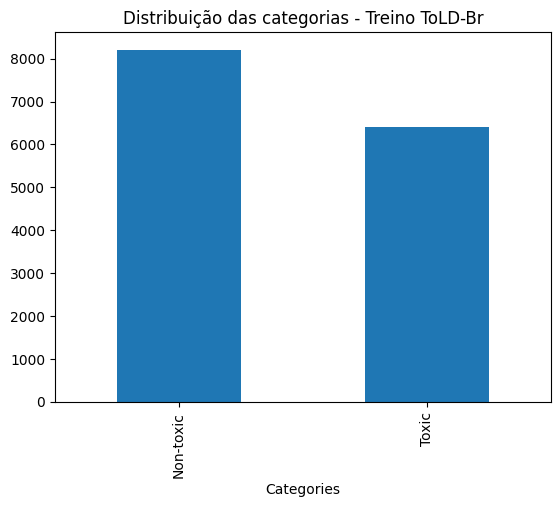

In [38]:
pd.DataFrame(train_df)['Categories'].value_counts().plot(kind='bar', title='Distribuição das categorias - Treino ToLD-Br')

In [33]:
def NDC_gzip(x1,x2):
    Cx1x2 = len(gzip.compress(" ".join([x1 , x2]).encode()))
    Cx1 = len(gzip.compress(x1.encode())) 
    Cx2 = len(gzip.compress(x2.encode()))

    return (Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2)

def NDC_bz2(x1,x2):
    Cx1x2 = len(bz2.compress(" ".join([x1 , x2]).encode()))
    Cx1 = len(bz2.compress(x1.encode())) 
    Cx2 = len(bz2.compress(x2.encode()))

    return (Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2)

In [34]:
def split_list(data, n):
    k, m = divmod(len(data), n)
    return [data[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

def cal_KNN_NDC(test_set):
    K = 1
    y_hat = []

    for (x1 , _) in tqdm(test_set):
        distances_to_xtest = []
        for (x2 , _) in training_set:
            distances_to_xtest.append(NDC_gzip(x1, x2))
        
        sorted_idx = np.argsort(distances_to_xtest)
        k_nearest = sorted_idx[:K]
        y_hat.append(training_set[max(set(k_nearest), key=k_nearest.tolist().count)][1])

    return y_hat


workers = 10

results = []
with concurrent.futures.ProcessPoolExecutor() as executor:
    splited_data =  split_list(test_set, workers)
    processed = executor.map(cal_KNN_NDC, splited_data)

    for result in processed:
        results.append(result)

y_hat = [item for sublist in results for item in sublist]

100%|██████████| 210/210 [03:15<00:00,  1.07it/s]


Accuracy: 0.6033333333333334
Recall: 0.6026617634182646
Precision: 0.6022088034323851
F1 Score: 0.6021814637438879


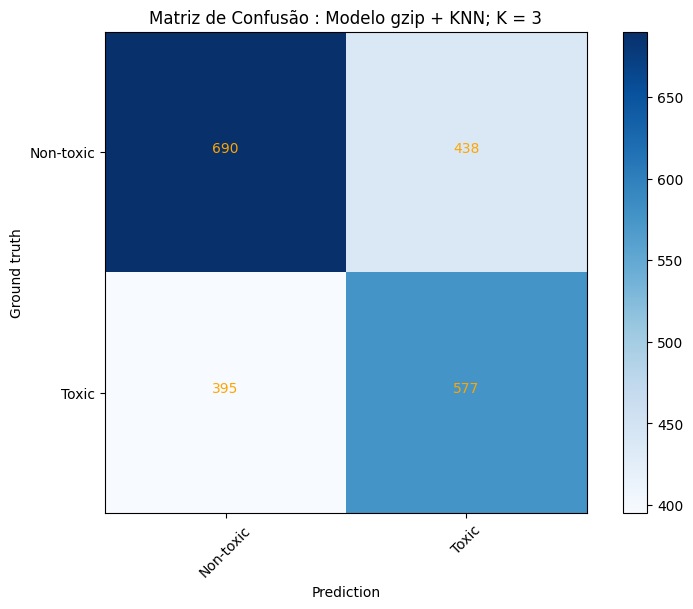

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

y_test = [y for (_, y) in test_set]

#compute accuracy
accuracy = sum([y_hat[i] == y_test[i] for i in range(len(y_test))]) / len(y_test)
print(f"Accuracy: {accuracy}")

#compute recall
recall = recall_score(y_test, y_hat, average='macro')
print(f"Recall: {recall}")

#compute precision
precision = precision_score(y_test, y_hat, average='macro')
print(f"Precision: {precision}")

#compute f1 score
f1 = f1_score(y_test, y_hat, average='macro')
print(f"F1 Score: {f1}")

conf_matrix = confusion_matrix(y_test, y_hat)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão : Modelo gzip + KNN; K = 3')
plt.colorbar()


tick_marks = np.arange(len(Categories))
plt.xticks(tick_marks, Categories, rotation=45)
plt.yticks(tick_marks, Categories)


thresh = conf_matrix.max() / 2.
for i, j in [(i, j) for i in range(conf_matrix.shape[0]) for j in range(conf_matrix.shape[1])]:
    plt.text(j, i, conf_matrix[i, j], horizontalalignment="center", color="orange" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Ground truth')
plt.xlabel('Prediction')
plt.show()